# Genetic Algorithm: CartPole-v0

We will use Open AI Gym environment to simulate a simple game known as CartPole-v0 and then we will use GA to automate the playing of the game.

### Problem Statement
A pole is standing upright on the cart. The goal is to balance the pole in an upright position by moving the cart left or right. You lose the game if the angle of the pole with the cart is more than 15 degrees. You win the game if you manage to keep the pole balanced for given number of frames. For every frame you mange to keep the pole in upright position you get a ‘+1’ score.

### Solution
To solve this problem we will first create some random game data and then we will feed it to our GA model which in turn will predict the movement of cart(left or right) for every frame. For those of you new to GA, do refer to my previous tutorials.
As usual, we begin with importing libraries and making necessary initializations.

In a very common perspective, RL is something which is always attracting people to work on. Efforts like gym making it more reachable, but still hardware is the big hurdle to cross. Availability of enough computing power or the time consumption to train the model is always be an issue for a starter.

Google Colaboratory provides that 12GB GPU support with continuous 12 hr runtime. For RL it requires to render the environment visuals. Here is sort of a tutorial to get over that issue & continue free coding.

Most of the requirements of python packages are already fulfilled on colab. To run gym, 1st you have to install prerequisites like xvbf,opengl & other python-dev packages:

In [1]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg- dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Unable to locate package libjpeg
E: Unable to locate package dev
E: Package 'libav-tools' has no installation candidate


In [2]:
!pip install pyvirtualdisplay
!pip install piglet

In [3]:
!pip install gym['all']

  Using cached https://files.pythonhosted.org/packages/cf/8c/64e0630b3d450244feef0688d90eab2448631e40ba6bdbd90a70b84898e7/mujoco-py-1.50.1.68.tar.gz
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-h_q9zxrh/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-h_q9zxrh/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-4z0lj511/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [0]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from statistics import mean, median
from collections import Counter
env = gym.make("CartPole-v0")
env.reset()
#Number of frames
goal_steps = 500
score_requirement = 50
initial_games = 10000

In [0]:
def create_data():
    training_data, scores, accepted_scores = [], [], []
    for _ in range(initial_games):
        score = 0
        #Moves from current environment and previous observations
        game_memory, prev_observation = [], []
        for _ in range(goal_steps):
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
                
            prev_observation = observation
            score += reward
            
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                training_data.append(data)
                    
        env.reset()        
        scores.append(score)
       
    print('Average accepted score:', mean(accepted_scores))
    print('Median accepted score:', median(accepted_scores))
        
    return training_data

In [0]:
def create_initial_pop(pop_size):
    initial_pop = np.random.uniform(low = -2.0, high = 2.0, size = pop_size)
    print('Initial Population:\n{}'.format(initial_pop))
    return initial_pop

def sigmoid(z):
    return 1/(1+np.exp(-z))

def predict(X):
    pred = np.empty((X.shape[0], 1))
    for i in range(X.shape[0]):
        if X[i] >= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
    return pred

In [0]:
def cal_fitness(population, X, y, pop_size):
    fitness = np.empty((pop_size[0], 1))
    for i in range(pop_size[0]):
        hx  = X@(population[i]).T
        fitness[i][0] = np.sum(hx)
    return fitness

In [0]:

def selection(population, fitness, num_parents):
    fitness = list(fitness)
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

In [0]:
def crossover(parents, num_offsprings):
    offsprings = np.empty((num_offsprings, parents.shape[1]))
    crossover_point = int(parents.shape[1]/2)
    crossover_rate = 0.8
    i=0
    while (parents.shape[0] < num_offsprings):
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        x = random.random()
        if x > crossover_rate:
            continue
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        offsprings[i,0:crossover_point] = parents[parent1_index,0:crossover_point]
        offsprings[i,crossover_point:] = parents[parent2_index,crossover_point:]
        i=+1
    return offsprings

In [0]:
def mutation(offsprings):
    mutants = np.empty((offsprings.shape))
    mutation_rate = 0.4
    for i in range(mutants.shape[0]):
        random_value = random.random()
        mutants[i,:] = offsprings[i,:]
        if random_value > mutation_rate:
            continue
        int_random_value = randint(0,offsprings.shape[1]-1)    
        mutants[i,int_random_value] += np.random.uniform(-1.0, 1.0, 1)
        
    return mutants

In [0]:
def GA_model(training_data):
    X = np.array([i[0] for i in training_data])
    y = np.array([i[1] for i in training_data]).reshape(-1, 1)
    
    weights, fitness_history = [], []
    num_solutions = 8
    pop_size = (num_solutions, X.shape[1])
    num_parents = int(pop_size[0]/2)
    num_offsprings = pop_size[0] - num_parents 
    num_generations = 50
    
    population = create_initial_pop(pop_size)
    
    for i in range(num_generations):
        fitness = cal_fitness(population, X, y, pop_size)
        fitness_history.append(fitness)
        parents = selection(population, fitness, num_parents)
        offsprings = crossover(parents, num_offsprings)
        mutants = mutation(offsprings)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutants
    
    fitness_last_gen = cal_fitness(population, X, y, pop_size)
    max_fitness = np.where(fitness_last_gen == np.max(fitness_last_gen))
    weights.append(population[max_fitness[0][0],:])
    return weights, fitness_history

In [12]:
def GA_model_predict(test_data, weights):
    hx = sigmoid(test_data@(weights).T)
    pred = predict(hx)
    pred = pred.astype(int)
    return pred[0][0]

training_data = create_data()
weights, fitness_history = GA_model(training_data)
print('Weights: {}'.format(weights))
weights = np.asarray(weights)

Average accepted score: 60.666666666666664
Median accepted score: 57.0
Initial Population:
[[-0.09877547  0.50133835  1.61102915 -0.2939037 ]
 [-0.8214619  -0.01610558  0.54461359  1.67382087]
 [ 0.27897021  0.44152795  1.45159995 -1.58559947]
 [-0.53387436 -0.18057193  0.96595269  0.19509061]
 [ 0.41039495  1.50019159  0.85678028  1.94440838]
 [ 0.71226573  0.81386573  1.11612863 -0.68112485]
 [-1.48250734 -1.19678314 -0.38078993  0.44974494]
 [ 1.79213355 -1.4205662  -1.46350816  0.59835061]]
Weights: [array([ 2.36632801, -2.49584314, -1.46350816,  5.36178189])]


In [0]:
num_generations = 50

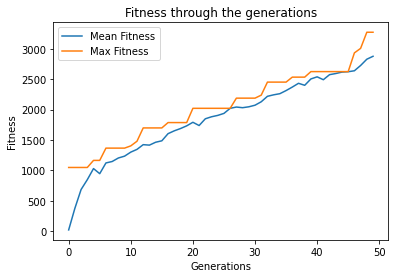

In [14]:
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

## End of the Notebook